In [1]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy.contrasts import Diff
import scipy.stats as stats
import pandas as pd 
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('../data/regression_data.csv')
ttest_data = pd.read_csv('../data/ttest_df.csv')

In [3]:
data

,trial,imv,exp_error,prev_exp_error,previous_uncertainty_y,current_uncertainty,endpoint_theta,fb_int
0,20,4.031846,17.464974,0.000000,no_uncertainty,high_uncertainty,0.810139,-2.662796
1,21,7.948700,17.611264,17.464974,high_uncertainty,high_uncertainty,4.753390,-2.741645
2,22,8.467662,16.111169,17.611264,high_uncertainty,high_uncertainty,6.053357,-2.106830
3,23,4.463121,18.682419,16.111169,high_uncertainty,unlimited_uncertainty,4.686294,-0.073983
4,24,0.159346,10.217554,18.682419,unlimited_uncertainty,no_uncertainty,1.151095,1.073440
...,...,...,...,...,...,...,...,...
175,195,7.118863,23.806355,27.717180,low_uncertainty,high_uncertainty,11.770796,4.126693
176,196,8.209852,29.573715,23.806355,high_uncertainty,unlimited_uncertainty,11.390018,2.786430
177,197,8.956556,17.822112,29.573715,unlimited_uncertainty,low_uncertainty,12.537492,2.914396
178,198,15.380658,30.404128,17.822112,low_uncertainty,unlimited_uncertainty,12.300822,-2.320524


In [4]:
# log transform initial movement vector/theta 
data['log_imv'] = np.log(data.imv)
data

,trial,imv,exp_error,prev_exp_error,previous_uncertainty_y,current_uncertainty,endpoint_theta,fb_int,log_imv
0,20,4.031846,17.464974,0.000000,no_uncertainty,high_uncertainty,0.810139,-2.662796,1.394224
1,21,7.948700,17.611264,17.464974,high_uncertainty,high_uncertainty,4.753390,-2.741645,2.073008
2,22,8.467662,16.111169,17.611264,high_uncertainty,high_uncertainty,6.053357,-2.106830,2.136254
3,23,4.463121,18.682419,16.111169,high_uncertainty,unlimited_uncertainty,4.686294,-0.073983,1.495848
4,24,0.159346,10.217554,18.682419,unlimited_uncertainty,no_uncertainty,1.151095,1.073440,-1.836676
...,...,...,...,...,...,...,...,...,...
175,195,7.118863,23.806355,27.717180,low_uncertainty,high_uncertainty,11.770796,4.126693,1.962748
176,196,8.209852,29.573715,23.806355,high_uncertainty,unlimited_uncertainty,11.390018,2.786430,2.105335
177,197,8.956556,17.822112,29.573715,unlimited_uncertainty,low_uncertainty,12.537492,2.914396,2.192386
178,198,15.380658,30.404128,17.822112,low_uncertainty,unlimited_uncertainty,12.300822,-2.320524,2.733111


In [5]:
data['z_imv'] = 1 / data.imv
data['z_trial'] = 1 / data.trial
data['z_prev_exp_error'] = 1 / data.prev_exp_error

In [6]:
data['log_trial'] = np.log(data.trial)
data['log_prev_exp_error']  = np.log(data.prev_exp_error)


/Users/dhruvadave/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# data['z_score'] = (data['log_imv'] - data['log_imv'].mean()) / data['log_imv'].std()
# outliers = data[np.abs(data['z_score']) > 3]

# # 4 outliers (more than 3 sd) but only in the adaptation phase. 
# outliers

In [8]:
# #Remove outliers 
# cleaned_data = data[np.abs(data['z_score']) <= 3].copy()

# cleaned_data


In [9]:
# calculate the change in IMV/initial theta from trial to the next trial and natural log transform
data['change_imv'] = np.diff(a=data.imv, n=1, axis=-1, prepend=0)

data['log_change_imv'] = np.log(abs(data.change_imv))


In [10]:
# log trasform endpoint_theta 
data['log_endpoint'] = np.log10(abs(90 - data.endpoint_theta))

In [11]:
# create formulas for feedforward adaptation regressions 
formula = 'log_imv ~ trial + C(previous_uncertainty_y, Diff) * prev_exp_error + 1'
formula_2 = 'log_change_imv ~ C(previous_uncertainty_y, Diff) * prev_exp_error + 1 '

# formula for feedback integration regression 
formula_3 = 'fb_int ~ C(current_uncertainty, Diff) * exp_error'

# Endpoint formula 
formula_4 = 'log_endpoint ~ C(previous_uncertainty_y, Diff) * prev_exp_error + 1'


In [12]:
data = data.replace([np.nan, np.inf], 0)

### Regression 1: 
Regresses initial movement vector (imv) on midpoint error (exp_error), trial (log_trial) and midpoint sensory uncertainty on the previous trial (previous_uncertainty_y) as well as the interaction between midpoint error and uncertainty on the previous trial. 

In [14]:
# Regression 1 
# Create and train the linear regression model with statsmodels
model = smf.ols(formula, data=data)

# fit the model 
reg = model.fit()

# Get the summary of the regression model, including p-values
summary = reg.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                log_imv   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.886
Date:                Sun, 08 Oct 2023   Prob (F-statistic):             0.0650
Time:                        13:50:37   Log-Likelihood:                -239.33
No. Observations:                 180   AIC:                             496.7
Df Residuals:                     171   BIC:                             525.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

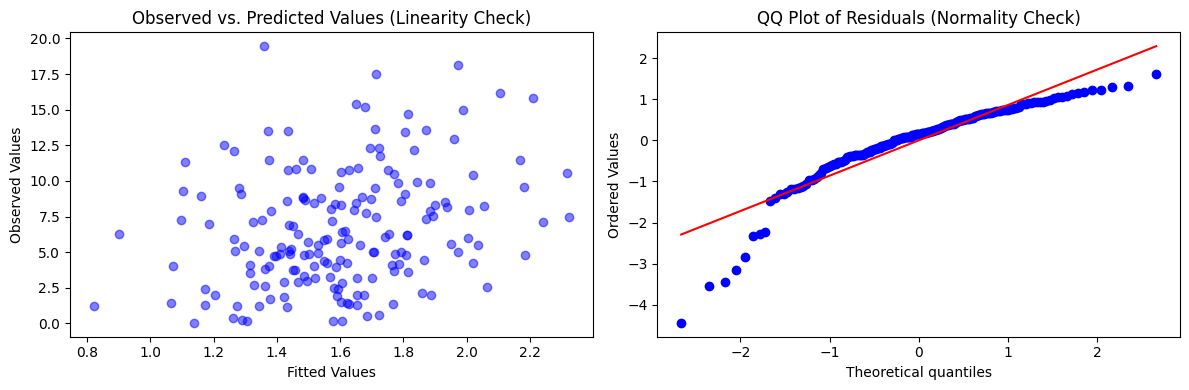

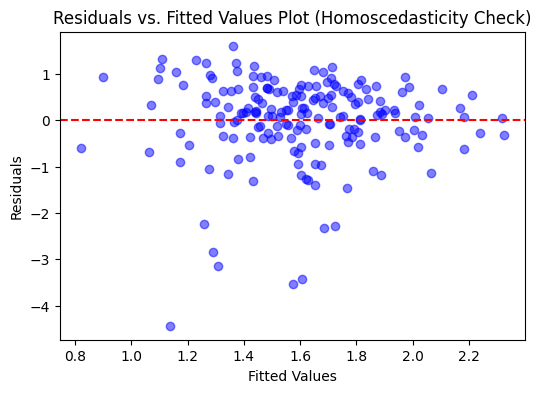

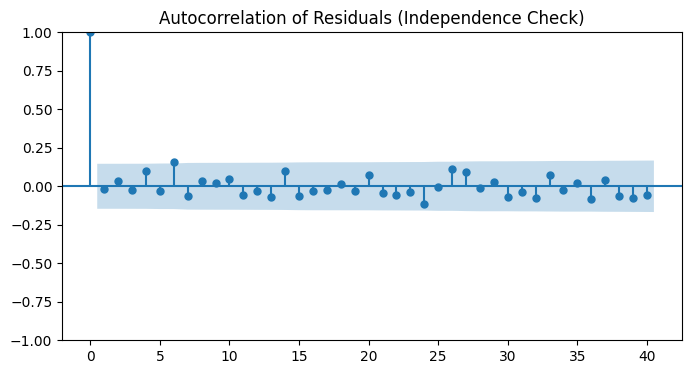

                                            Variable        VIF
0                                          Intercept  13.540103
1  C(previous_uncertainty_y, Diff)[D.high_uncerta...  20.189953
2  C(previous_uncertainty_y, Diff)[D.low_uncertai...  21.053881
3  C(previous_uncertainty_y, Diff)[D.no_uncertainty]  16.293210
4                                              trial   1.129319
5                                     prev_exp_error   1.129583
6  C(previous_uncertainty_y, Diff)[D.high_uncerta...  19.962294
7  C(previous_uncertainty_y, Diff)[D.low_uncertai...  20.487316
8  C(previous_uncertainty_y, Diff)[D.no_uncertain...  15.743258


In [15]:
residuals = reg.resid
fitted_values = reg.fittedvalues

# Linearity Check (Observed vs. Predicted)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, data['imv'], color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values (Linearity Check)')

# Normality of Residuals (QQ Plot)
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

# Homoscedasticity Check (Residuals vs. Fitted Values)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Independence of Residuals (Autocorrelation Plot)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, ax=ax, lags=40)
plt.title('Autocorrelation of Residuals (Independence Check)')
plt.show()

# Multicollinearity Check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = reg.model.data.orig_exog
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)



### Regression 2 
Regresses **change** in IMV (between trials) on midpoint error and midpoint sensory uncertainty on the previous trial as well as the interaction between midpoint error and uncertainty on the previous trial. 

In [16]:
# Regression 2
# Create and train the linear regression model with statsmodels
model_2 = smf.ols(formula_2, data=data)

# fit the model 
reg_2 = model_2.fit()

# Get the summary of the regression model, including p-values
summary_2 = reg_2.summary()
print(summary_2)

                            OLS Regression Results                            
Dep. Variable:         log_change_imv   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.5480
Date:                Sun, 08 Oct 2023   Prob (F-statistic):              0.797
Time:                        13:50:37   Log-Likelihood:                -276.37
No. Observations:                 180   AIC:                             568.7
Df Residuals:                     172   BIC:                             594.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

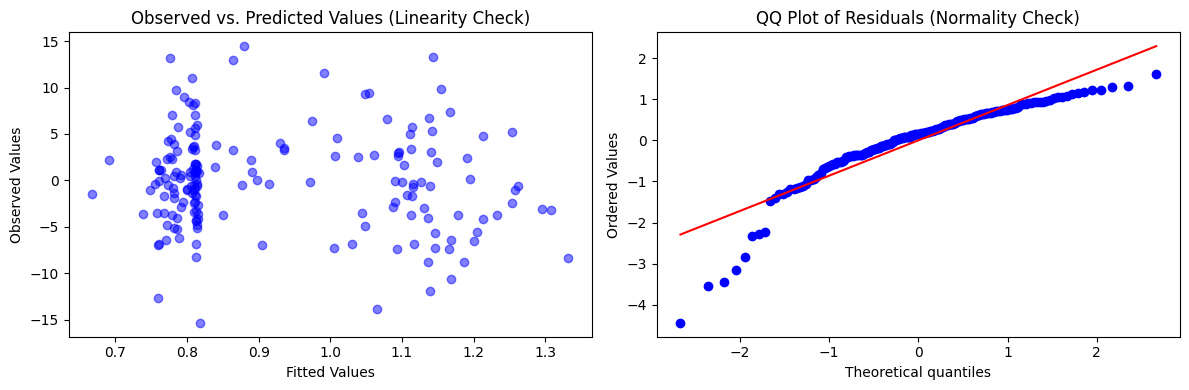

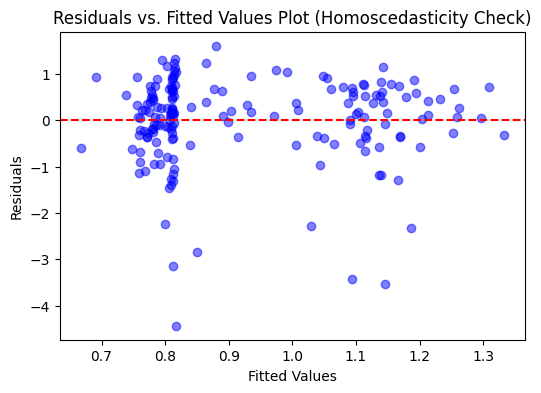

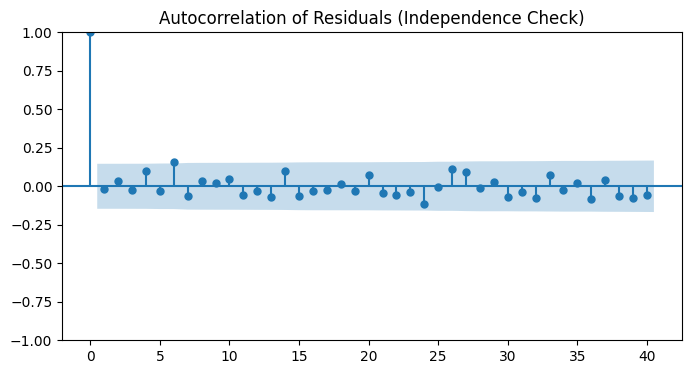

                                            Variable        VIF
0                                          Intercept  13.540103
1  C(previous_uncertainty_y, Diff)[D.high_uncerta...  20.189953
2  C(previous_uncertainty_y, Diff)[D.low_uncertai...  21.053881
3  C(previous_uncertainty_y, Diff)[D.no_uncertainty]  16.293210
4                                              trial   1.129319
5                                     prev_exp_error   1.129583
6  C(previous_uncertainty_y, Diff)[D.high_uncerta...  19.962294
7  C(previous_uncertainty_y, Diff)[D.low_uncertai...  20.487316
8  C(previous_uncertainty_y, Diff)[D.no_uncertain...  15.743258


In [17]:
#assumption testing 
residuals_2 = reg_2.resid
fitted_values = reg_2.fittedvalues

# Linearity Check (Observed vs. Predicted)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, data['change_imv'], color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values (Linearity Check)')

# Normality of Residuals (QQ Plot)
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

# Homoscedasticity Check (Residuals vs. Fitted Values)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Independence of Residuals (Autocorrelation Plot)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, ax=ax, lags=40)
plt.title('Autocorrelation of Residuals (Independence Check)')
plt.show()

# Multicollinearity Check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = reg.model.data.orig_exog
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


In [18]:
# endpoint regression 
# Create and train the linear regression model with statsmodels
model_4 = smf.ols(formula_4, data=data)

# fit the model 
reg_4 = model_4.fit()

# Get the summary of the regression model, including p-values
summary_4 = reg_4.summary()
print(summary_4)

                            OLS Regression Results                            
Dep. Variable:           log_endpoint   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4.482
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           0.000131
Time:                        13:50:38   Log-Likelihood:                 454.23
No. Observations:                 180   AIC:                            -892.5
Df Residuals:                     172   BIC:                            -866.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

NameError: name 'x' is not defined

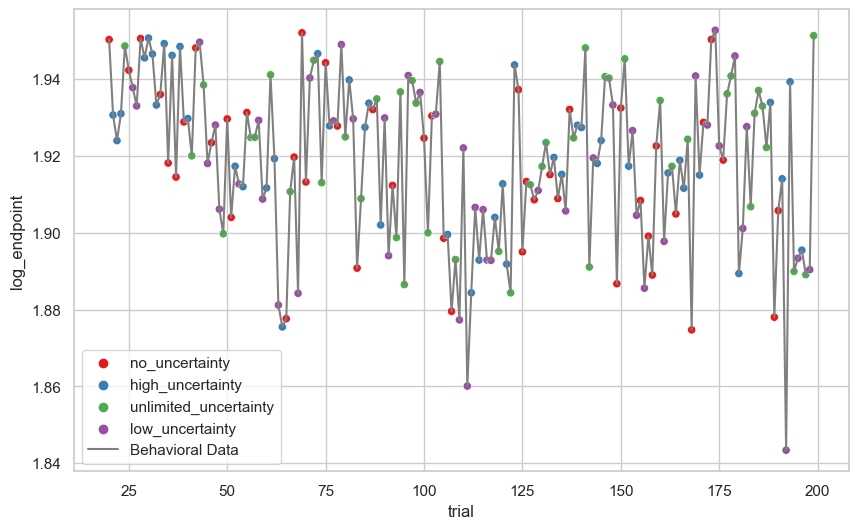

In [19]:

# Predict IMV for regression model 3 (reg)
predicted_endpoint = reg_4.predict(data)

# style and size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a color palette based on previous_uncertainty levels
palette = sns.color_palette("Set1", n_colors=len(data['previous_uncertainty_y'].unique()))

# Create a scatter plot for color-coding the behavioral data points
sns.scatterplot(x="trial", y="log_endpoint", hue="previous_uncertainty_y", data=data, palette=palette, legend=True)

# Plot the behavioral data as a line
sns.lineplot(x="trial", y="log_endpoint", data=data, color='grey', label='Behavioral Data')

# Plot the predicted initial_theta from the regression model
plt.plot(x, predicted_endpoint, label='Predicted Data', linestyle='-', color='orange')

# Labels
plt.xlabel('Trial')
plt.ylabel('Endpoint Hange Angle')
plt.title('Behavioral Data vs. Predicted Endpoint Data')
plt.legend()
plt.grid(True)

# Show the legend
plt.legend(title="Previous Uncertainty", bbox_to_anchor= (1.25,1), loc='upper right')

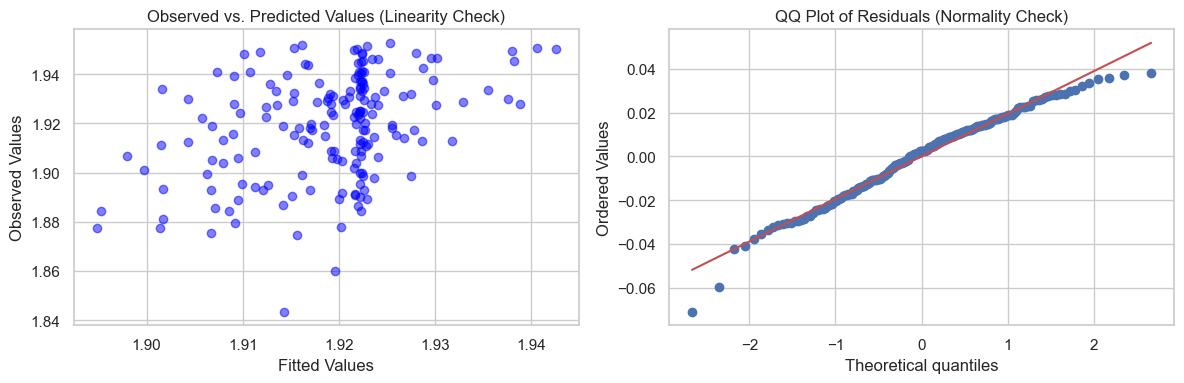

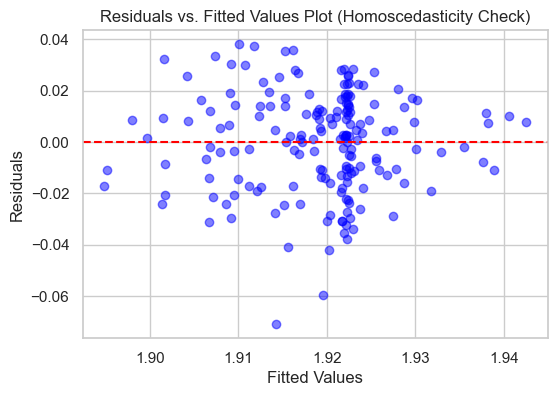

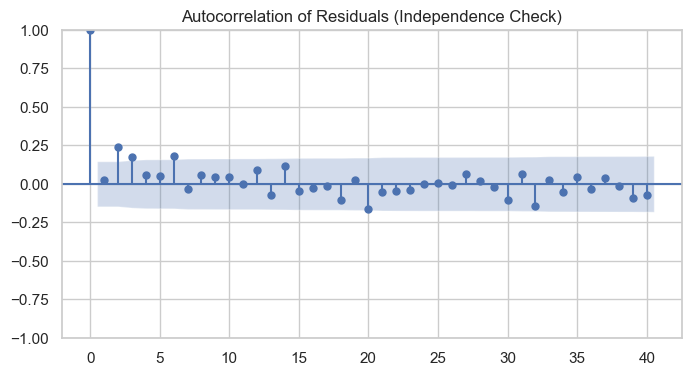

                                            Variable        VIF
0                                          Intercept  11.933196
1  C(previous_uncertainty_y, Diff)[D.high_uncerta...  19.645906
2  C(previous_uncertainty_y, Diff)[D.low_uncertai...  20.996356
3  C(previous_uncertainty_y, Diff)[D.no_uncertainty]  16.153681
4                                     prev_exp_error   1.041040
5  C(previous_uncertainty_y, Diff)[D.high_uncerta...  19.556604
6  C(previous_uncertainty_y, Diff)[D.low_uncertai...  20.471038
7  C(previous_uncertainty_y, Diff)[D.no_uncertain...  15.700548


In [ ]:
#assumption testing 
residuals_4 = reg_4.resid
fitted_values = reg_4.fittedvalues

# Linearity Check (Observed vs. Predicted)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, data['log_endpoint'], color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values (Linearity Check)')

# Normality of Residuals (QQ Plot)
plt.subplot(1, 2, 2)
stats.probplot(residuals_4, plot=plt)
plt.title('QQ Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

# Homoscedasticity Check (Residuals vs. Fitted Values)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals_4, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Independence of Residuals (Autocorrelation Plot)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals_4, ax=ax, lags=40)
plt.title('Autocorrelation of Residuals (Independence Check)')
plt.show()

# Multicollinearity Check (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = reg_4.model.data.orig_exog
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


### Repeated Measures / Paired T-test 
Compares the last 3 trials of the adaptaiton phase (trial 198 to 200) and the first 3 trials of the washout phase (trial 201 to 203). 

In [ ]:
ttest_data

,trial,imv
0,0,3.108024
1,1,1.179373
2,2,2.637969
3,3,2.108906
4,4,6.567590
...,...,...
295,295,9.961075
296,296,7.166902
297,297,2.360146
298,298,5.991040


In [ ]:
# ttest variables defined
adaptation = ttest_data.loc[(ttest_data.trial >= 197) & (ttest_data.trial <= 199)].copy()
washout = ttest_data.loc[(ttest_data.trial >= 200) & (ttest_data.trial <= 202)].copy()


In [ ]:
adaptation.imv.mean()

8.124719433849881

In [ ]:
adaptation.imv.std()

7.705605290297258

In [ ]:
washout.imv.mean()

8.510858107549439

In [ ]:
washout.imv.std()

1.7759554624389027

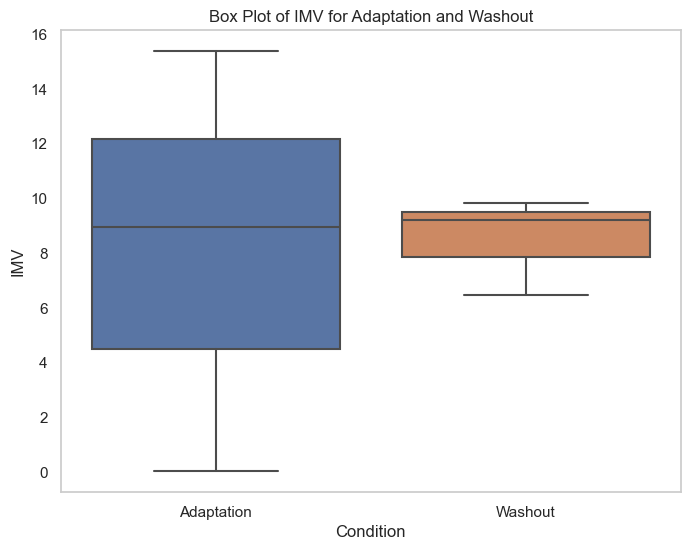

In [ ]:
# Data
adaptation_data = adaptation['imv']
washout_data = washout['imv']

# Combine data and labels into a single DataFrame
plt_data = pd.DataFrame({'Data': ['Adaptation'] * len(adaptation_data) + ['Washout'] * len(washout_data),
                     'IMV': list(adaptation_data) + list(washout_data)})

# Create the boxplot
plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
sns.boxplot(data=plt_data, x='Data', y='IMV')


# Set labels and title
plt.xlabel('Condition')
plt.ylabel('IMV')
plt.title('Box Plot of IMV for Adaptation and Washout')

plt.grid(False)


In [ ]:
stats.ttest_rel(adaptation.imv, washout.imv)

TtestResult(statistic=-0.07393449582864775, pvalue=0.9477917146159495, df=2)

In [ ]:
# Regression 3
# Create and train the linear regression model with statsmodels
model_3 = smf.ols(formula_3, data=data)

# fit the model 
reg_3 = model_3.fit()

# Get the summary of the regression model, including p-values
summary_3 = reg_3.summary()
print(summary_3)

                            OLS Regression Results                            
Dep. Variable:                 fb_int   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.407
Date:                Thu, 28 Sep 2023   Prob (F-statistic):             0.0225
Time:                        14:28:34   Log-Likelihood:                -377.64
No. Observations:                 180   AIC:                             771.3
Df Residuals:                     172   BIC:                             796.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

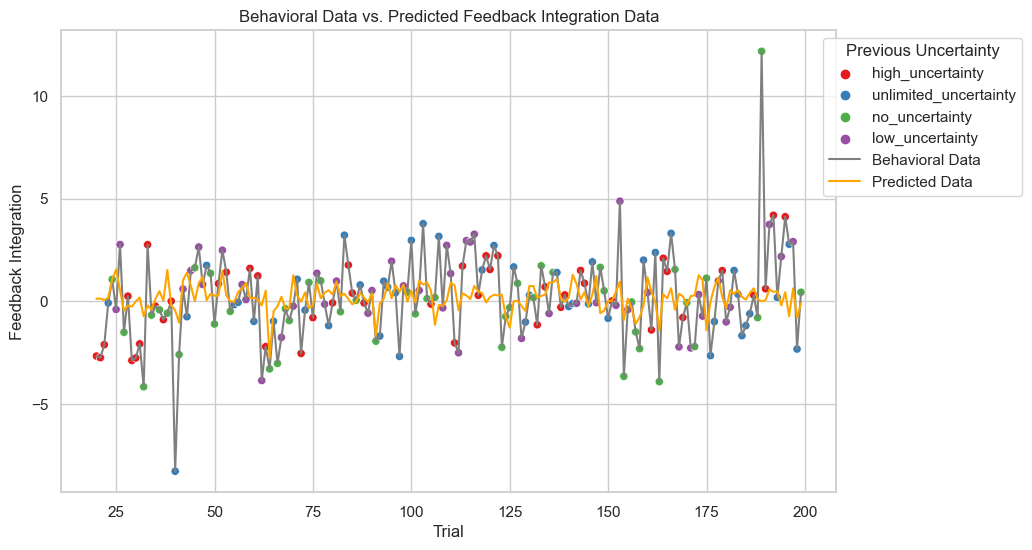

In [ ]:
x = data.trial

# Predict IMV for regression model 3 (reg)
predicted_fb_int = reg_3.predict(data)

# style and size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a color palette based on previous_uncertainty levels
palette = sns.color_palette("Set1", n_colors=len(data['current_uncertainty'].unique()))

# Create a scatter plot for color-coding the behavioral data points
sns.scatterplot(x="trial", y="fb_int", hue="current_uncertainty", data=data, palette=palette, legend=True)

# Plot the behavioral data as a line
sns.lineplot(x="trial", y="fb_int", data=data, color='grey', label='Behavioral Data')

# Plot the predicted initial_theta from the regression model
plt.plot(x, predicted_fb_int, label='Predicted Data', linestyle='-', color='orange')

# Labels
plt.xlabel('Trial')
plt.ylabel('Feedback Integration')
plt.title('Behavioral Data vs. Predicted Feedback Integration Data')
plt.legend()
plt.grid(True)

# Show the legend
plt.legend(title="Previous Uncertainty", bbox_to_anchor= (1.25,1), loc='upper right')



### Regression 1 behavioural vs predicted data

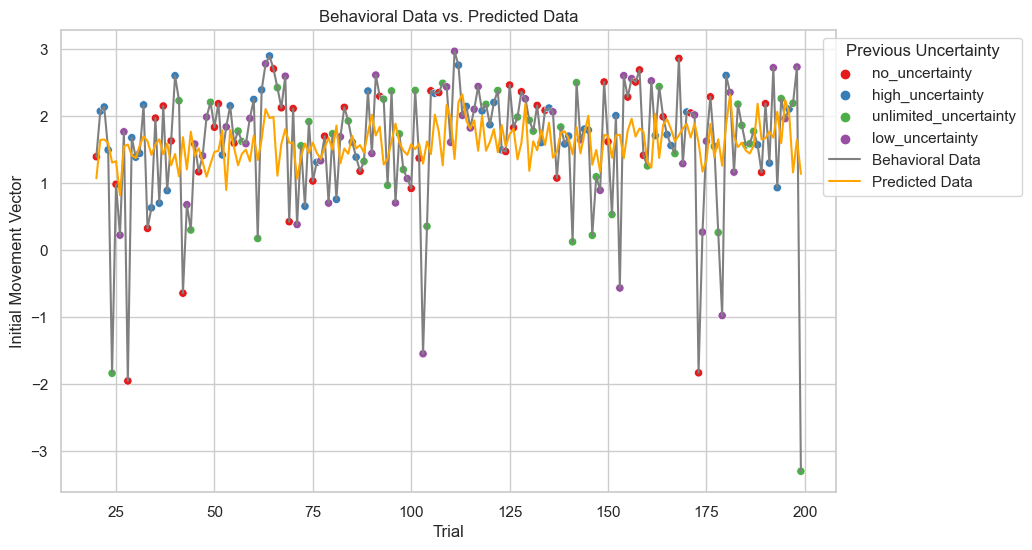

In [ ]:
x = data.trial

# Predict (log)IMV for regression model 1 (reg)
predicted_imv = reg.predict(data)

# style and size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a color palette based on previous_uncertainty levels
palette = sns.color_palette("Set1", n_colors=len(data['previous_uncertainty_y'].unique()))

# Create a scatter plot for color-coding the behavioral data points
sns.scatterplot(x="trial", y="log_imv", hue="previous_uncertainty_y", data=data, palette=palette, legend=True)

# Plot the behavioral data as a line
sns.lineplot(x="trial", y="log_imv", data=data, color='grey', label='Behavioral Data')

# Plot the predicted initial_theta from the regression model
plt.plot(x, predicted_imv, label='Predicted Data', linestyle='-', color='orange')

# Labels
plt.xlabel('Trial')
plt.ylabel('Initial Movement Vector')
plt.title('Behavioral Data vs. Predicted Data')
plt.legend()
plt.grid(True)

# Show the legend
plt.legend(title="Previous Uncertainty", bbox_to_anchor= (1.25,1), loc='upper right')



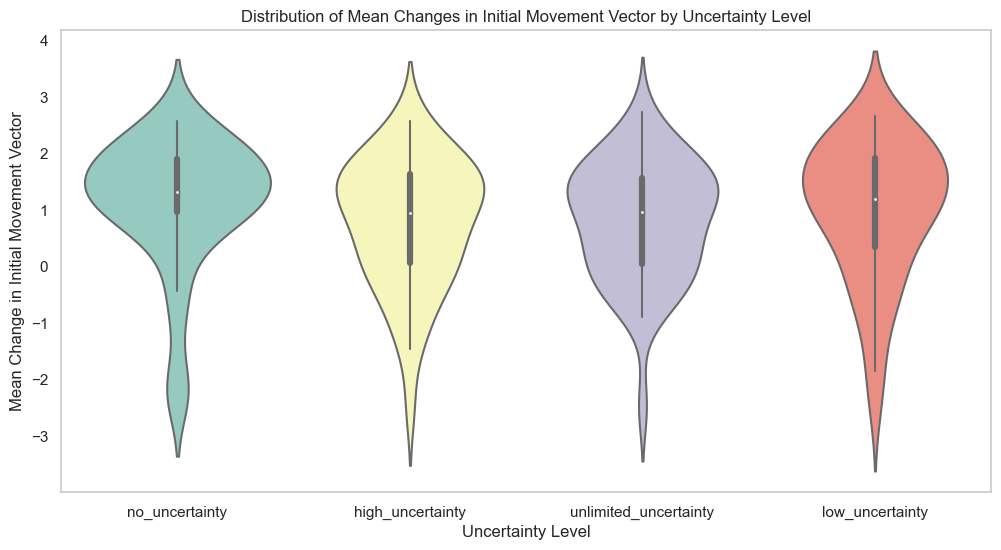

In [21]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create the Violin plot
sns.violinplot(x="previous_uncertainty_y", y="log_change_imv", data=data, inner="box", palette="Set3")

# labels and title
plt.xlabel("Uncertainty Level")
plt.ylabel("Mean Change in Initial Movement Vector")
plt.title("Distribution of Mean Changes in Initial Movement Vector by Uncertainty Level")

plt.grid(False)

Text(0.5, 1.0, 'Mean Change in Initial Movement Vector vs. Midpoint Error')

<Figure size 1200x600 with 0 Axes>

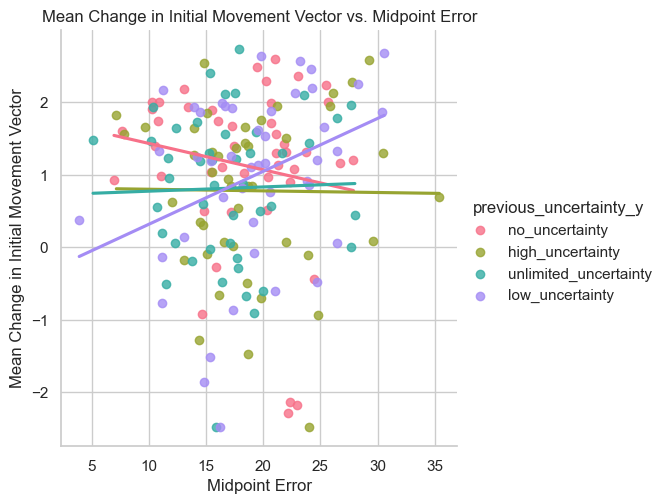

In [ ]:
# Set the style and size of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Create a scatter plot with regression lines
sns.lmplot(x="exp_error", y="log_change_imv", hue="previous_uncertainty_y", data=data, ci=None, palette="husl")

# Add labels and title
plt.xlabel("Midpoint Error")
plt.ylabel("Mean Change in Initial Movement Vector")
plt.title("Mean Change in Initial Movement Vector vs. Midpoint Error")



In [ ]:
# full_data['log_imv'] = np.log(full_data.initial_theta)
# full_data['z_score'] = (full_data['log_imv'] - full_data['log_imv'].mean()) / full_data['log_imv'].std()
# cleaned_data = full_data[np.abs(full_data['z_score']) <= 3].copy()

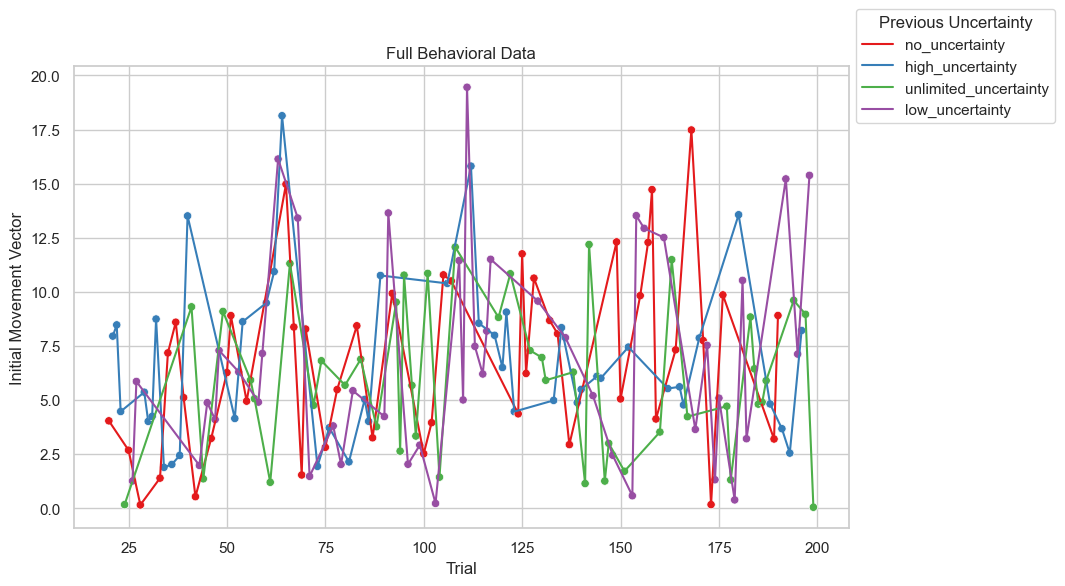

In [ ]:
plt.figure(figsize=(10, 6))
# Create a color palette based on previous_uncertainty levels
palette = sns.color_palette("Set1", n_colors=len(data['previous_uncertainty_y'].unique()))

# Plot the behavioral data as a line
sns.lineplot(x="trial", y="imv", data=data, hue='previous_uncertainty_y', palette=palette)

# Create a scatter plot for color-coding the behavioral data points
sns.scatterplot(x="trial", y="imv", hue="previous_uncertainty_y", data=data, palette=palette, legend=False)
# Labels
plt.xlabel('Trial')
plt.ylabel('Initial Movement Vector')
plt.title('Full Behavioral Data')
plt.legend(title="Previous Uncertainty", bbox_to_anchor=(1, 1), loc='center left')
plt.grid(True)


In [ ]:
endpoint = pd.read_csv('../data/endpoint_theta.csv')

In [ ]:
endpoint

,Unnamed: 0,trial,endpoint_theta,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,previous_uncertainty
0,0,0,0.254412,0.0,0.0,0.0,0.0,no_uncertainty
1,1,1,0.313775,0.0,0.0,0.0,0.0,no_uncertainty
2,2,2,0.148380,0.0,0.0,0.0,0.0,no_uncertainty
3,3,3,0.249147,0.0,0.0,0.0,0.0,no_uncertainty
4,4,4,0.243432,0.0,0.0,0.0,0.0,no_uncertainty
...,...,...,...,...,...,...,...,...
295,295,295,1.370994,0.0,0.0,0.0,0.0,unlimited_uncertainty
296,296,296,0.461591,0.0,0.0,0.0,0.0,unlimited_uncertainty
297,297,297,0.919627,0.0,0.0,0.0,0.0,unlimited_uncertainty
298,298,298,0.114328,0.0,0.0,0.0,0.0,unlimited_uncertainty


In [ ]:
# endpoint['log_emv'] = np.log(endpoint.endpoint_theta)

# endpoint['z_score'] = (endpoint['log_emv'] - endpoint['log_emv'].mean()) / endpoint['log_emv'].std()
# endpoint_outliers = endpoint[np.abs(endpoint['z_score']) > 3]

# endpoint_cleaned_data = endpoint[np.abs(endpoint['z_score']) <= 3].copy()

# endpoint_outliers #3 outliers (trial 9, 269 and 277)

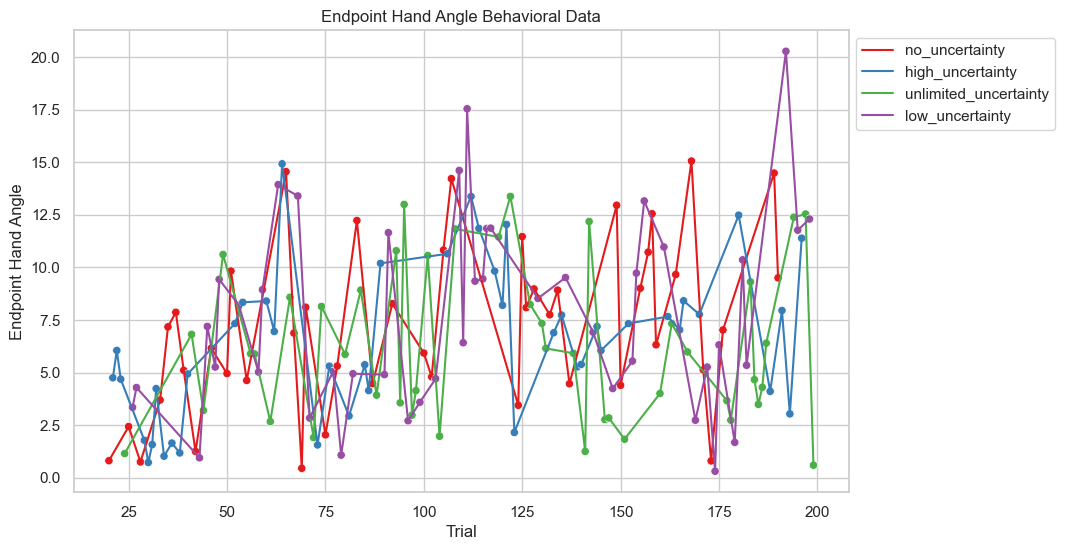

In [ ]:
plt.figure(figsize=(10, 6))

# Create a color palette based on previous_uncertainty levels
palette = sns.color_palette("Set1", n_colors=(len(data['previous_uncertainty_y'].unique())))

# Plot the behavioral data as a line
sns.lineplot(x="trial", y="endpoint_theta", data=data, hue='previous_uncertainty_y', palette=palette)

# Create a scatter plot for color-coding the behavioral data points
sns.scatterplot(x="trial", y="endpoint_theta", hue="previous_uncertainty_y", data=data, palette=palette, legend=False)
# Labels
plt.xlabel('Trial')
plt.ylabel('Endpoint Hand Angle')
plt.title('Endpoint Hand Angle Behavioral Data')
plt.legend(bbox_to_anchor=(1 ,1))
plt.grid(True)
